<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Оценка-качества-данных" data-toc-modified-id="Оценка-качества-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Оценка качества данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression-классификатор" data-toc-modified-id="Logistic-Regression-классификатор-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression классификатор</a></span></li><li><span><a href="#Decision-Tree-классификатор" data-toc-modified-id="Decision-Tree-классификатор-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Decision Tree классификатор</a></span></li><li><span><a href="#CatBoost-классификатор" data-toc-modified-id="CatBoost-классификатор-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoost классификатор</a></span></li></ul></li>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [108]:
# загрузка библиотек
import re
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
#from sklearn.externals import joblib
import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fomen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fomen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fomen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [109]:
# загрузка файла
#df = pd.read_csv('/datasets/toxic_comments.csv')
df = pd.read_csv('toxic_comments.csv') #для запуска на локальном компьютере

###  Оценка качества данных

In [110]:
# получение первых 5 строк таблицы
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [111]:
# получение последних 5 строк таблицы
df.tail()

,text,toxic
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0
159570,"""\nAnd ... I really don't think you understand...",0


In [112]:
# общий анализ данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [113]:
# проверка на наличие пропущенных значений
print('Всего NaN:',df.isnull().sum())

Всего NaN: text     0
toxic    0
dtype: int64


In [114]:
# проверка на дубликаты
print('Количество дубликатов',df.duplicated().sum())

Количество дубликатов 0


In [115]:
# проверка численных значений методом descibe() для объектов
df.describe(include='object')

,text
count,159571
unique,159571
top,Explanation\nWhy the edits made under my usern...
freq,1


In [116]:
# проверка на баланс классов
display(df['toxic'].value_counts())
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
print('Ratio:',class_ratio)

0    143346
1     16225
Name: toxic, dtype: int64

Ratio: 8.834884437596301


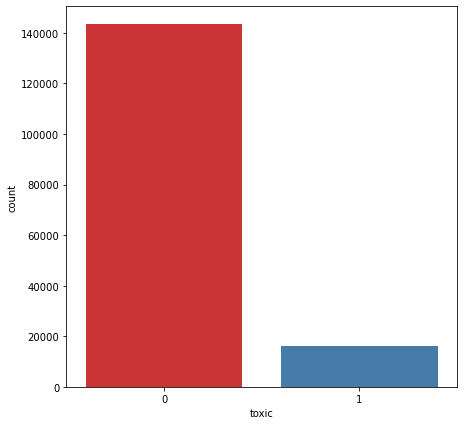

In [117]:
# визуализиция дисбаланса классов на графике
plt.figure(figsize=(7, 7))
sns.countplot(x='toxic', data=df, palette="Set1");

**Вывод:** Набор данных всего содержит 159571 строк и 2 столбца. Результаты:
1. В данных нет пропущенных значений и дубликатов
2. Язык текста комментариев - английский
3. В тексте комментариев содержатся разные регистры букв, символы пунктуации и '/n' итд.
4. Найден дисбаланс классов в соотношении примерно 1:8

Займемся обработкой данных

### Предобработка данных

* **Лемматизация**

Приведение текста в столбце 'text' к нижнему регистру

In [118]:
df['text'] = df['text'].str.lower()

In [119]:
# проверка на дубликаты
print('Количество дубликатов',df.duplicated().sum())

Количество дубликатов 45


После приведения текста к нижнему регистру, обнаружены дубликаты. Удалим их

In [120]:
df = df.drop_duplicates().reset_index(drop= True)

Объявим корпус текстов, переведем его в тип юникод

In [121]:
corpus = df['text'].values
print(corpus[0])

explanation
why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27


Для обработки текста, объявим лемматизатор и функцию для очистки и лемматизации текстов "clear_text"

In [122]:
display(df['toxic'].value_counts())
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
class_ratio

0    143316
1     16210
Name: toxic, dtype: int64

8.841209130166565

In [123]:
# функция для лемматизирования текста
wnl = WordNetLemmatizer()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(wnl.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

df['lemm_text'] = df['text'].apply(lemmatize_text)

df = df.drop(['text'], axis=1)

In [124]:
# проверка
display(df.head(10))

,toxic,lemm_text
0,0,explanation why the edits made under my userna...
1,0,d aww he matches this background colour i m se...
2,0,hey man i m really not trying to edit war it s...
3,0,more i can t make any real suggestions on impr...
4,0,you sir are my hero any chance you remember wh...
5,0,congratulations from me as well use the tools ...
6,1,cocksucker before you piss around on my work
7,0,your vandalism to the matt shirvington article...
8,0,sorry if the word nonsense was offensive to yo...
9,0,alignment on this subject and which are contra...


<div class="alert alert-block alert-success">
<b>Успех:</b> Очистка и лемматизация были сделаны верно.
</div>

* **Разделение данных на выборки**

Подготовим признаки (features и target), разобьем их на train, valid и test выборки. 

In [125]:
# разбивка данных на features, target
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12082020)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12082020)



In [126]:
# проверка
print(target_train.shape)
print(features_train.shape)

(95715,)
(95715, 1)


In [127]:
# загрузим стоп-слова
stop_words = set(nltk_stopwords.words('english'))

In [128]:
# объявление TFIDF-векторизатора
count_tfidf = TfidfVectorizer(stop_words=stop_words)

In [129]:
# расчет tfdif в каждой из выборок по признаков с типом данных Unicode
features_train = count_tfidf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_valid = count_tfidf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tfidf.transform(features_test['lemm_text'].values.astype('U'))

In [130]:
# проверка
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

(95715, 125098)
(31905, 125098)
(31906, 125098)


### Ресемплирование

Ранее было обнаружено, что классы в данных несбалансированы. Для балансировки классов уменьшим количество значений в классе 0 (downsampling) метод. Увеличение класса 1 использовать не будем из-за большого объема данных.

In [131]:
# балансировка target_train 
toxic_comments_train = df.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [132]:
# балансировка features_train 
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12082020)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = df.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12082020)
features_train_downsample = count_tfidf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))

In [133]:
# проверка
print(target_train.shape)
print(features_train.shape)

(95715,)
(95715, 125098)


Готово.

**Вывод:** 
В ходе преподготовки признаки были разделены на обучающую, валидационную и тестовую выборки. Текст комментариев приведен к нижнему регистру, удалены дубликаты, сбалансированы классы.

## Обучение

Нам необходимо эффективно подобрать наиболее эффективную модель, то есть проанализировать несколько модели и сравнить их RMSE моделей (оценка качества) и выбрать ту которая наиболее близка к нулю. Также отследим время обучения моделей. Мы обучим и проанализируем следующие модели:

* LogisticRegression
* Random Forest
* CatBoostClassifier

### Logistic Regression классификатор

In [134]:
%%time
dict_classes={0:1, 1:8.83}
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=5)
clf.fit(features_train, target_train)
LR_best_params = clf.best_params_
print(LR_best_params)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'lbfgs'}

Grid scores on development set:

0.715999 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'newton-cg'}
0.715998 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'lbfgs'}
0.715864 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'liblinear'}
0.755471 for {'C': 1, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'newton-cg'}
0.755531 for {'C': 1, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'lbfgs'}
0.755494 for {'C': 1, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'liblinear'}
0.763239 for {'C': 10, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'newton-cg'}
0.763411 for {'C': 10, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'lbfgs'}
0.763239 for {'C': 10, 'class_weight': {0: 1, 1: 8.83}, 'solver': 'liblinear'}

Wall time: 2min 3s


In [135]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7634113971999236
F1 на валидации 0.7709480577466884
Wall time: 4.63 s


### Decision Tree классификатор

In [137]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12082020],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
DTC_best_params = clf.best_params_
print(DTC_best_params)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

{'class_weight': {0: 1, 1: 8.83}, 'max_depth': 44, 'random_state': 12082020}
0.624640 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 30, 'random_state': 12082020}
0.615247 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 32, 'random_state': 12082020}
0.617295 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 34, 'random_state': 12082020}
0.612196 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 36, 'random_state': 12082020}
0.619892 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 38, 'random_state': 12082020}
0.621880 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 40, 'random_state': 12082020}
0.625879 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 42, 'random_state': 12082020}
0.628508 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 44, 'random_state': 12082020}
0.604223 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 46, 'random_state': 12082020}
0.607819 for {'class_weight': {0: 1, 1: 8.83}, 'max_depth': 48, 'random_state': 12082020}
0.613250 for {'class_we

In [138]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6285083143838285
F1 на валидации 0.6511318242343542
Wall time: 32.2 s


### CatBoost классификатор

In [139]:
%%time

classificator = CatBoostClassifier(verbose=False, iterations=30)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

F1 на cv 0.6828613561949272
F1 на валидации 0.6830122591943958
Wall time: 3min 27s


**Вывод:** Всего было проанализированно 3 модели, среди которых:

|модели|время обучения|качество valid(F1_score)|
|---|---|---|
|LogisticRegression|5.49s|0.77|
|DecisionTree|31.6s|0.65|
|CatBoost|3m 27s|0.68|

Самой быстрой моделью является модель Logistic Regression (5.49s), F1 этой модели (0.77) примерно равен F1 Catboost (0.73) но по скорости Catboost  уступает(Catboost - 20 min),  У Decision Tree F1 = 0.65, при скорости обучения модели 31.6s. Чем ближе f1_score модели к 1, тем модель лучше предсказывает. 

**Вывод:** Чем ближе f1_score модели к 1, тем модель лучше предсказывает. Для тестирования оставляем модель логистической регрессии

# Проверка модели на тестовой выборке

In [140]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_test)
valid_f1_LR = f1_score(target_test, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7634113971999236
F1 на валидации 0.7706772440135155
Wall time: 5.08 s


Прстроим ROC кривую и оценим качество обучения модели

Значение AUC-ROC =  0.8854289915033529


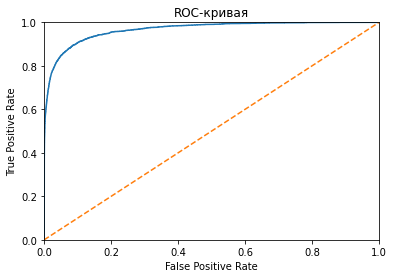

In [141]:
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, target_predict)

print('Значение AUC-ROC = ',auc_roc)



fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод:** F1 валидационной и тестовой выборкок = 0.77. Это хороший результат и отсутствие разницы означает, что модель не переобучилась.
Логистическая регрессия дала хорогие результаты в ROC AUC метрике. Модель способна обработать больше записей.

# Общий вывод

В ходе работы над данными было сделано следующее:
1) Подготовленны данные обучения на моделях.
2) Выбран способ баланса классов и поделены данные на обучающую, валидационную и тестовою выборку.
3) Обучены модели и выбраны лучшие из них на валидационной выборке.
4) Показаны параметры качества моделей.


Мы подобрали и построили модель для сортировки токсичных комментариев. Logistic Regression - модель с наилучшим значением F1, равным 0.77 на тестовой выборке и на валидационной. Время обучения в среднем равно 0.5 секундам.